## Данные

Данные в [архиве](https://drive.google.com/file/d/15o7fdxTgndoy6K-e7g8g1M2-bOOwqZPl/view?usp=sharing). В нём два файла:
- `news_train.txt` тренировочное множество
- `news_test.txt` тренировочное множество

С некоторых новостных сайтов были загружены тексты новостей за период  несколько лет, причем каждая новость принаделжит к какой-то рубрике: `science`, `style`, `culture`, `life`, `economics`, `business`, `travel`, `forces`, `media`, `sport`.

В каждой строке файла содержится метка рубрики, заголовок новостной статьи и сам текст статьи, например:

>    **sport**&nbsp;&lt;tab&gt;&nbsp;**Сборная Канады по хоккею разгромила чехов**&nbsp;&lt;tab&gt;&nbsp;**Сборная Канады по хоккею крупно об...**

# Задача

1. Обработать данные, получив для каждого текста набор токенов
Обработать токены с помощью (один вариант из трех):
    - pymorphy2
    - русского [snowball стеммера](https://www.nltk.org/howto/stem.html)
    - [SentencePiece](https://github.com/google/sentencepiece) или [Huggingface Tokenizers](https://github.com/huggingface/tokenizers)
    
    
2. Обучить word embeddings (fastText, word2vec, gloVe) на тренировочных данных. Можно использовать [gensim](https://radimrehurek.com/gensim/models/word2vec.html) . Продемонстрировать семантические ассоциации. 

3. Реализовать алгоритм классификации, посчитать точноть на тестовых данных, подобрать гиперпараметры. Метод векторизации выбрать произвольно - можно использовать $tf-idf$ с понижением размерности (см. scikit-learn), можно использовать обученные на предыдущем шаге векторные представления, можно использовать [предобученные модели](https://rusvectores.org/ru/models/). Имейте ввиду, что простое "усреднение" токенов в тексте скорее всего не даст положительных результатов. Нужно реализовать два алгоритмов из трех:
     - SVM
     - наивный байесовский классификатор
     - логистическая регрессия
    

4.* Реализуйте классификацию с помощью нейросетевых моделей. Например [RuBERT](http://docs.deeppavlov.ai/en/master/features/models/bert.html) или [ELMo](https://rusvectores.org/ru/models/).

In [6]:
def normalize_text(text):
    text = re.findall(r'\b\w+\b', text.lower())
    return ' '.join(text)


def prepare_file(f_out, data):
    with open(f_out, 'w', encoding='utf-8') as f:
        for cat, headline, text in data:
            f.write(normalize_text(headline))
            f.write('\n')
            
            sents = (sent for sent in re.split(r'[.!?]', text) if len(sent) > 20)
    
            for sent in sents:
                f.write(normalize_text(sent))
                f.write('\n')


In [7]:
import re
import smart_open as sm

def read_data(path='/content/news.txt.gz'):
    with sm.open(path, encoding='utf-8') as f:
        for line in f:
            cat, headline, text = line.strip().split('\t')
            yield cat, headline, text
prepare_file('/content/news_train.txt', read_data())
!head -n 5 /content/news_train.txt

rolex наградит победителей регаты
парусная гонка giraglia rolex cup пройдет в средиземном море в 64 й раз
победители соревнования проводимого с 1953 года yacht club italiano помимо других призов традиционно получают в подарок часы от швейцарского бренда rolex
об этом сообщается в пресс релизе поступившем в редакцию ленты
rolex yacht master 40 фото пресс служба mercury соревнования будут проходить с 10 по 18 июня


In [8]:
!pip install sentencepiece
import sentencepiece as spm
spm.SentencePieceTrainer.Train('--input=/content/news_train.txt --model_prefix=model  --vocab_size=7000')

In [9]:
model = spm.SentencePieceProcessor(model_file='/content/model.model')
model.EncodeAsPieces('ремонт')

['▁ремонт']

In [10]:
from gensim.models import Word2Vec
sentences = [model.EncodeAsPieces(line.strip()) for line in open('/content/news_train.txt', encoding='utf-8', errors='ignore')]
w2v = Word2Vec(sentences)
w2v.wv.save_word2vec_format('/content/w2v_vectors.bin')

In [11]:
w2v.wv.most_similar(model.EncodeAsPieces('ремонт'))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('▁десант', 0.7085727453231812),
 ('▁пожар', 0.7067148685455322),
 ('▁молодеж', 0.6930320262908936),
 ('▁выявлен', 0.6883028745651245),
 ('▁масштаб', 0.6807860136032104),
 ('▁свадеб', 0.6799383759498596),
 ('▁дорож', 0.67743980884552),
 ('▁похищен', 0.6746872663497925),
 ('▁атом', 0.6698674559593201),
 ('▁расширен', 0.6687107682228088)]

In [12]:
import numpy as np
emb_size = w2v.wv.vector_size
def _piece_id_to_vect(piece_id):
    piece = model.id_to_piece(piece_id) 
    for smallpiece in piece:
        if smallpiece in w2v.wv:
            return w2v.wv[smallpiece]
        return np.zeros((emb_size,))
emb = np.array([_piece_id_to_vect(piece_id) for piece_id in range(0, len(model))])
np.save('vectors.npy', emb)

In [13]:
categories ={cat for (cat, _, _) in read_data()}
categories = {cat:idx for (idx, cat) in enumerate(categories)}
categories

{'business': 1,
 'culture': 2,
 'economics': 5,
 'forces': 8,
 'life': 6,
 'media': 9,
 'science': 4,
 'sport': 7,
 'style': 3,
 'travel': 0}

In [14]:
def prepare_text(text):
    pieces = model.EncodeAsIds(text)
    pieces = pieces[:120]
    for i in range(0, 120 - len(pieces)):
            pieces.append(0)
    return np.array(pieces)

def prepare_data():
    X = []
    y = []
    for cat,headline,text in read_data():
        X.append(prepare_text(headline+' '+text))
        y.append(categories[cat])
    return np.array(X), np.array(y)

X, y = prepare_data()
print(X)
print(y)

[[   8    0 1185 ... 1209   26    8]
 [   8    0    5 ...    8    0  818]
 [   8    0 1031 ...    8    0   67]
 ...
 [   8    0   19 ...    0 6260   28]
 [   8    0  269 ...  823    8    0]
 [   8    0   19 ...    3   32 3271]]
[3 7 9 ... 6 9 8]


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional
from torch.utils.data import TensorDataset, DataLoader, random_split,Dataset

In [16]:
emb_layer = nn.Embedding.from_pretrained(torch.tensor(emb), padding_idx=model.pad_id())


In [17]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 
X = torch.LongTensor(X)
X.to(device)
y = y.reshape(-1,1)
y = torch.LongTensor(y)
l = len(X)
print(X)
y.to(device)
data = TensorDataset(X, y)
print(data)
train_data, test_data, val_data = random_split(data, [int(l * 0.7), int(l * 0.2), l - int(l * 0.7) - int(l * 0.2)])
print(X.shape)
y.shape

tensor([[   8,    0, 1185,  ..., 1209,   26,    8],
        [   8,    0,    5,  ...,    8,    0,  818],
        [   8,    0, 1031,  ...,    8,    0,   67],
        ...,
        [   8,    0,   19,  ...,    0, 6260,   28],
        [   8,    0,  269,  ...,  823,    8,    0],
        [   8,    0,   19,  ...,    3,   32, 3271]])
torch.Size([10000, 120])


torch.Size([10000, 1])

In [18]:
model = nn.Sequential(nn.EmbeddingBag.from_pretrained(torch.FloatTensor(emb)),nn.Linear(emb.shape[1], 10),nn.Linear(10, 10),nn.Softmax(dim=1)).to(device)


Epoch = 0, acc = 93.35885714285715, loss = 2.2664129734039307
Epoch = 5, acc = 20.142857142857142, loss = 1.5275580883026123
Epoch = 10, acc = 20.142857142857142, loss = 1.4850131273269653
Epoch = 15, acc = 20.142857142857142, loss = 1.4878826141357422
Epoch = 20, acc = 20.142857142857142, loss = 1.485174298286438
Epoch = 25, acc = 20.142857142857142, loss = 1.4822618961334229
Epoch = 30, acc = 20.142857142857142, loss = 1.4809824228286743
Epoch = 35, acc = 20.142857142857142, loss = 1.4800984859466553
Epoch = 40, acc = 20.142857142857142, loss = 1.4796217679977417
Epoch = 45, acc = 20.142857142857142, loss = 1.4779449701309204
Epoch = 50, acc = 20.142857142857142, loss = 1.4783583879470825
Epoch = 55, acc = 20.142857142857142, loss = 1.4785254001617432
Epoch = 60, acc = 20.142857142857142, loss = 1.4775692224502563
Epoch = 65, acc = 20.142857142857142, loss = 1.4768937826156616
Epoch = 70, acc = 20.142857142857142, loss = 1.4768203496932983
Epoch = 75, acc = 20.142857142857142, loss =

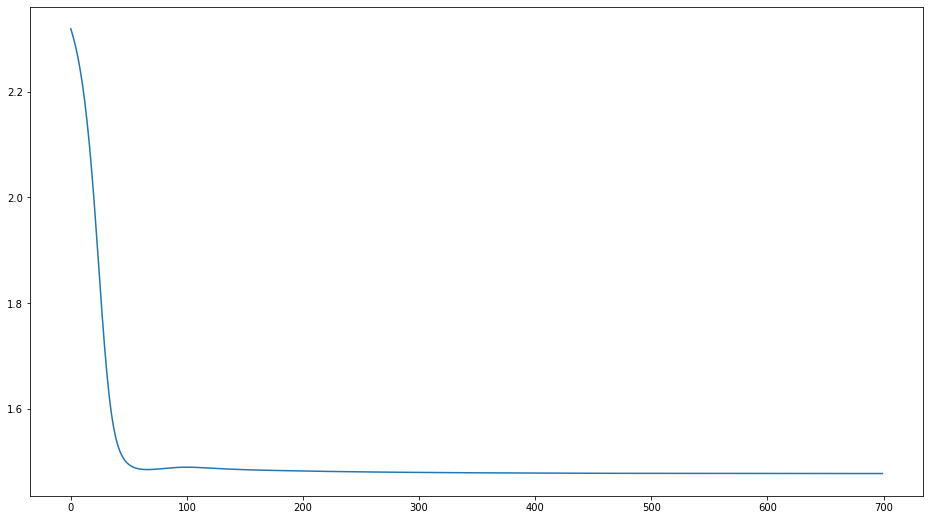

In [19]:
import matplotlib.pyplot as plt
def train_model(model, train_data, val_data, max_epochs=100):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=0.1)
    loss = nn.CrossEntropyLoss()
    train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)
    for epoch in range(max_epochs):
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            model = model.train()
            y_pred = model(X_batch)
            loss1 = loss(y_pred, torch.max(y_batch, 1)[1])
            losses.append(loss(model(X),torch.max(y, 1)[1]))
            total += y_batch.size(0)
            correct += (y_pred.argmax(1) == y_batch).sum().item()
            loss1.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 5 == 0:
            acc = correct / total
            print(f'Epoch = {epoch}, acc = {acc}, loss = {loss1}')
            #print(f'VAL:  Epoch = {epoch},acc ={Validate(model,val_data)} ')
    return losses
losses = train_model(model, train_data, val_data)
plt.figure(figsize=(16, 9))
plt.plot(losses)
plt.show()

In [26]:
from sklearn.naive_bayes import MultinomialNB
model_G =MultinomialNB()
model_G.fit(X, y)
predicted= model_G.predict(X)
print(predicted)
print(y)

[3 5 3 ... 4 5 8]
tensor([[3],
        [7],
        [9],
        ...,
        [6],
        [9],
        [8]])


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
